In [36]:
import logging

import bcause.util.domainutils as dutils
import networkx as nx
import numpy as np
import pandas as pd
from bcause.factors import DeterministicFactor, MultinomialFactor
from bcause.inference.causal.elimination import CausalVariableElimination
from bcause.inference.causal.multi import EMCC
from bcause.models.cmodel import StructuralCausalModel
from matplotlib import pyplot as plt
from bcause.util import randomUtil

logging.disable(level=logging.CRITICAL)

# Definindo o DAG

In [37]:
edges = [
    ('NewDeploy', 'MemoryLeak'),
    ('MemoryLeak', 'MemoryUsageHigh'), 
    ("MemoryUsageHigh", "ServiceCrash"), 
    ("ServiceCrash", "OutageIncident"),
    ("HeavyTraffic", "MemoryUsageHigh"), 
    ("HeavyTraffic", "ServiceCrash"),
    ('Unob_helper_1', 'MemoryLeak'),
    ('Unob_helper_2', 'OutageIncident'),
    ('Unob_helper_3', 'NewDeploy'),
]

model_edges = [
    ('NewDeploy', 'MemoryLeak'),
    ('MemoryLeak', 'MemoryUsageHigh'), 
    ("MemoryUsageHigh", "ServiceCrash"), 
    ("ServiceCrash", "OutageIncident"),
    ("HeavyTraffic", "MemoryUsageHigh"), 
    ("HeavyTraffic", "ServiceCrash")
]
dag = nx.DiGraph(edges)
model_1 = nx.DiGraph(model_edges)

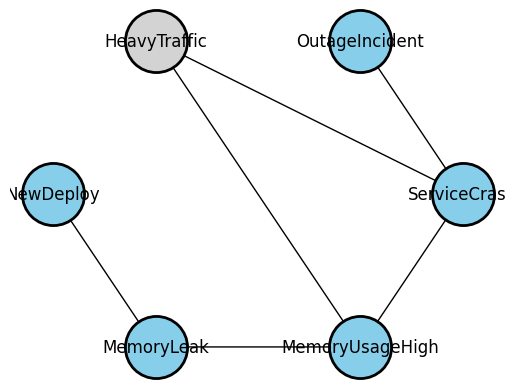

In [38]:
G = model_1

latent_nodes = {'HeavyTraffic', 'Unob_helper_1', 'Unob_helper_2', 'Unob_helper_3'}
node_colors = ['lightgray' if node in latent_nodes else 'skyblue' for node in G.nodes()]
node_styles = ['dashed' if node in latent_nodes else 'solid' for node in G.nodes()]

pos = nx.shell_layout(G)

for node, style in zip(G.nodes(), node_styles):
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node],
                           node_color='lightgray' if node in latent_nodes else 'skyblue',
                           node_size=2000,
                           edgecolors='black',
                           linewidths=2,
                           node_shape='o')
    if style == 'dashed':
        circle = plt.Circle(pos[node], 0.05, color='black', fill=False, linestyle='dashed')
        plt.gca().add_artist(circle)

nx.draw_networkx_edges(G, pos, arrows=True)

nx.draw_networkx_labels(G, pos, font_size=12)

plt.axis('off')
plt.show()

# Definindo domínios e funções

In [39]:
domains = dict(MemoryLeak=[0,1], 
                MemoryUsageHigh=[0,1], 
                ServiceCrash=[0,1], 
                OutageIncident=[0,1], 
                HeavyTraffic=list(np.arange(16)), 
                NewDeploy=[0,1],
                Unob_helper_1=list(np.arange(4)),
                Unob_helper_2=list(np.arange(4)),
                Unob_helper_3=[0,1])

In [40]:
dom_NewDeploy = dutils.var_parents_domain(domains, dag, 'NewDeploy')
print(dom_NewDeploy)

dom_MemoryLeak = dutils.var_parents_domain(domains, dag, 'MemoryLeak')
print(dom_MemoryLeak)

dom_MemoryUsageHigh = dutils.var_parents_domain(domains, dag, 'MemoryUsageHigh')
print(dom_MemoryUsageHigh)

dom_ServiceCrash = dutils.var_parents_domain(domains, dag, 'ServiceCrash')
print(dom_ServiceCrash)

dom_OutageIncident = dutils.var_parents_domain(domains, dag, 'OutageIncident')
print(dom_OutageIncident)

dom_HeavyTraffic = dutils.subdomain(domains, 'HeavyTraffic')
print(dom_HeavyTraffic)

dom_Unob_helper_1 = dutils.subdomain(domains, 'Unob_helper_1')
print(dom_Unob_helper_1)

dom_Unob_helper_2 = dutils.subdomain(domains, 'Unob_helper_2')
print(dom_Unob_helper_2)

dom_Unob_helper_3 = dutils.subdomain(domains, 'Unob_helper_3')
print(dom_Unob_helper_3)

{'Unob_helper_3': [0, 1], 'NewDeploy': [0, 1]}
{'NewDeploy': [0, 1], 'Unob_helper_1': [0, 1, 2, 3], 'MemoryLeak': [0, 1]}
{'MemoryLeak': [0, 1], 'HeavyTraffic': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'MemoryUsageHigh': [0, 1]}
{'MemoryUsageHigh': [0, 1], 'HeavyTraffic': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'ServiceCrash': [0, 1]}
{'ServiceCrash': [0, 1], 'Unob_helper_2': [0, 1, 2, 3], 'OutageIncident': [0, 1]}
{'HeavyTraffic': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
{'Unob_helper_1': [0, 1, 2, 3]}
{'Unob_helper_2': [0, 1, 2, 3]}
{'Unob_helper_3': [0, 1]}


### Para definir as funções usaremos o seguinte critério:

- Não-observadas = MultinomialFactor => Aleatórias
- Observadas = DeterministicFactor => Funções "determínisticas" => Levam em consideração os pais endógenos e as funções reposta definidas pela exógena



In [51]:
pu_u1 = MultinomialFactor(dom_Unob_helper_1, [1/4]*4)
pu_u2 = MultinomialFactor(dom_Unob_helper_2, [1/4]*4)
pu_u3 = MultinomialFactor(dom_Unob_helper_3, [0.9, 0.1])
p_ht = MultinomialFactor(dom_HeavyTraffic, [1/16]*16)

# NewDeploy = identity(Unob_helper_3)
f_nd = DeterministicFactor(
    dom_NewDeploy,        # [0, 1]
    values=[0, 1],               # when Unob_helper_3=0 → NewDeploy=0; when Unob_helper_3=1 → NewDeploy=1
    left_vars=['NewDeploy'],
    right_vars=['Unob_helper_3']
)

ml_vals = []
for nd in domains["MemoryLeak"]:
    for u1 in domains["Unob_helper_1"]:
        u1 = int(nd)
        # pick the function by index:
        #   0 → always 0
        #   1 → identity (nd)
        #   2 → negation (1−nd)
        #   3 → always 1
        ml_vals.append([0, nd, 1-nd, 1][u1])

f_ml = DeterministicFactor(
    dom_MemoryLeak,
    values=ml_vals,
    left_vars=['MemoryLeak'],
    right_vars=['NewDeploy', 'Unob_helper_1']
)

#    MemoryUsageHigh ← f_muh(MemoryLeak, HeavyTraffic)
#    where code = HT & 0b11 picks one of {const0, id, not, const1}
muh_vals = []
for ml in domains["MemoryLeak"]:
    ml = int(ml)
    for ht in domains["HeavyTraffic"]:
        ht = int(ht)
        code = ht & 0b11
        if code == 0:
            muh_vals.append(0)
        elif code == 1:
            muh_vals.append(ml)
        elif code == 2:
            muh_vals.append(1 - ml)
        else:  # code == 3
            muh_vals.append(1)

f_muh = DeterministicFactor(
    dom_MemoryUsageHigh,
    values=muh_vals,
    left_vars=['MemoryUsageHigh'],
    right_vars=['MemoryLeak', 'HeavyTraffic']
)

#    ServiceCrash ← f_sc(MemoryUsageHigh, HeavyTraffic)
#    where code = (HT >> 2) & 0b11 picks one of {const0, id, not, const1}
fsc_vals = []
for muh in domains["MemoryUsageHigh"]:
    muh = int(muh)
    for ht in domains["HeavyTraffic"]:
        ht = int(ht)
        code = (ht >> 2) & 0b11
        if code == 0:
            fsc_vals.append(0)
        elif code == 1:
            fsc_vals.append(muh)
        elif code == 2:
            fsc_vals.append(1 - muh)
        else:  # code == 3
            fsc_vals.append(1)

f_sc = DeterministicFactor(
    dom_ServiceCrash,
    values=fsc_vals,
    left_vars=['ServiceCrash'],
    right_vars=['MemoryUsageHigh', 'HeavyTraffic']
)

oi_vals = []
for sc in domains["ServiceCrash"]:
    sc = int(sc)
    for u2 in domains["Unob_helper_2"]:
        u2 = int(u2)
        oi_vals.append([0, sc, 1-sc, 1][u2])

f_oi = DeterministicFactor(
    dom_OutageIncident,
    values=oi_vals,
    left_vars=['OutageIncident'],
    right_vars=['ServiceCrash', 'Unob_helper_2']
)

# Criando o SCM

In [42]:
model = StructuralCausalModel(dag, [f_nd, f_ml, f_muh, f_sc, f_oi, pu_u1,pu_u2, pu_u3, p_ht])
model

<StructuralCausalModel (NewDeploy:2,MemoryLeak:2,MemoryUsageHigh:2,ServiceCrash:2,OutageIncident:2|HeavyTraffic:16,Unob_helper_1:4,Unob_helper_2:4,Unob_helper_3:2), dag=[NewDeploy|Unob_helper_3][MemoryLeak|NewDeploy:Unob_helper_1][MemoryUsageHigh|MemoryLeak:HeavyTraffic][ServiceCrash|MemoryUsageHigh:HeavyTraffic][OutageIncident|ServiceCrash:Unob_helper_2][HeavyTraffic][Unob_helper_1][Unob_helper_2][Unob_helper_3]>

In [43]:
model.factors

{'NewDeploy': <MultinomialFactor P(NewDeploy|Unob_helper_3), cardinality = (Unob_helper_3:2,NewDeploy:2), values=[1.0,0.0,0.0,1.0]>,
 'MemoryLeak': <MultinomialFactor P(MemoryLeak|NewDeploy,Unob_helper_1), cardinality = (NewDeploy:2,Unob_helper_1:4,MemoryLeak:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'MemoryUsageHigh': <MultinomialFactor P(MemoryUsageHigh|MemoryLeak,HeavyTraffic), cardinality = (MemoryLeak:2,HeavyTraffic:16,MemoryUsageHigh:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'ServiceCrash': <MultinomialFactor P(ServiceCrash|MemoryUsageHigh,HeavyTraffic), cardinality = (MemoryUsageHigh:2,HeavyTraffic:16,ServiceCrash:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'OutageIncident': <MultinomialFactor P(OutageIncident|ServiceCrash,Unob_helper_2), cardinality = (ServiceCrash:2,Unob_helper_2:4,OutageIncident:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'HeavyTraffic': <MultinomialFactor P(HeavyTraffic), cardinality = (HeavyTraffic:16), values=[0.0625,0.0625,0.0625,0.0625,...,0.0625]>,
 'Unob_helper_1'

# Gerando os dados

In [44]:
def generate_small_model_data(n_samples=1000, include_latent=False, seed=42):
    """Generate a synthetic dataset for the small-scale causal model.
    Returns a pandas DataFrame with n_samples rows following the DAG:
    NewDeploy -> MemoryLeak -> MemoryUsageHigh -> ServiceCrash -> OutageIncident,
    with a latent HeavyTraffic influencing MemoryUsageHigh and ServiceCrash.
    If include_latent is True, the latent HeavyTraffic column is included for reference."""
    
    rng = np.random.default_rng(seed) 

    # 10% of times a new deploy happens
    Deploy_NewVersion = rng.binomial(1, 0.1, size=n_samples)  
    
    # MemoryLeakBug: if a new version is deployed, there's a high chance it introduces a bug
    MemoryLeakBug = np.zeros(n_samples, dtype=int)
    # e.g., 90% chance the new deployment has the memory leak bug
    MemoryLeakBug[Deploy_NewVersion == 1] = rng.binomial(1, 0.8, size=np.sum(Deploy_NewVersion == 1))
    MemoryLeakBug[Deploy_NewVersion == 0] = rng.binomial(1, 0.2, size=np.sum(Deploy_NewVersion == 0))
    # include a small probability of bug without deployment
    
    # Latent heavy traffic surge (unobserved)
    HeavyTraffic = rng.binomial(1, 0.1, size=n_samples)  # 10% chance of a heavy traffic spike in a time window
    
    # MemoryUsageHigh: can be caused by MemoryLeakBug or HeavyTraffic (or both)
    MemoryUsageHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if MemoryLeakBug[i] == 1 and HeavyTraffic[i] == 1:
            # Both bug and heavy traffic -> very high chance of high memory usage
            MemoryUsageHigh[i] = rng.binomial(1, 0.95)
        elif MemoryLeakBug[i] == 1 and HeavyTraffic[i] == 0:
            # Bug alone -> high memory usage likely, but not guaranteed immediately
            MemoryUsageHigh[i] = rng.binomial(1, 0.8)
        elif MemoryLeakBug[i] == 0 and HeavyTraffic[i] == 1:
            # Heavy traffic alone -> can cause high memory usage due to load
            MemoryUsageHigh[i] = rng.binomial(1, 0.5)
        else:
            # Neither bug nor heavy traffic -> low baseline chance of high memory (e.g., other minor factors)
            MemoryUsageHigh[i] = rng.binomial(1, 0.15)
    
    # ServiceCrash: can be caused by MemoryUsageHigh or directly by HeavyTraffic (e.g., CPU overload crash)
    ServiceCrash = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if MemoryUsageHigh[i] == 1:
            # If memory is high, there's a strong chance of crash
            ServiceCrash[i] = rng.binomial(1, 0.9)
        elif MemoryUsageHigh[i] == 0 and HeavyTraffic[i] == 1:
            # Even without high memory, heavy traffic might cause a crash due to other overload (e.g., CPU)
            ServiceCrash[i] = rng.binomial(1, 0.5)
        else:
            # No high memory and no heavy traffic -> very low chance of crash (random hardware failure, etc.)
            ServiceCrash[i] = rng.binomial(1, 0.05)
    
    # OutageIncident: we consider an outage if the service crashed (could also incorporate high error as criteria)
    OutageIncident = ServiceCrash.copy()  # Outage happens whenever there's a crash in this simple model
    
    data = {
        "NewDeploy": Deploy_NewVersion,
        "MemoryLeak": MemoryLeakBug,
        "MemoryUsageHigh": MemoryUsageHigh,
        "ServiceCrash": ServiceCrash,
        "OutageIncident": OutageIncident
    }
    if include_latent:
        data["[HeavyTraffic]"] = HeavyTraffic  # include latent for reference if needed
    df = pd.DataFrame(data)
    return df

In [45]:
df = generate_small_model_data(n_samples=10000)
df

,NewDeploy,MemoryLeak,MemoryUsageHigh,ServiceCrash,OutageIncident
0,0,0,0,0,0
1,0,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,0
4,0,1,1,0,0
...,...,...,...,...,...
9995,0,1,0,0,0
9996,0,0,1,1,1
9997,0,1,1,0,0
9998,0,0,0,1,1


# Criando o EMCC

In [46]:
inf = EMCC(model, df, max_iter=100, num_runs=20)
p = inf.causal_query("OutageIncident", do=dict(NewDeploy=0))

In [53]:
inf.model.factors

{'NewDeploy': <MultinomialFactor P(NewDeploy|Unob_helper_3), cardinality = (Unob_helper_3:2,NewDeploy:2), values=[1.0,0.0,0.0,1.0]>,
 'MemoryLeak': <MultinomialFactor P(MemoryLeak|NewDeploy,Unob_helper_1), cardinality = (NewDeploy:2,Unob_helper_1:4,MemoryLeak:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'MemoryUsageHigh': <MultinomialFactor P(MemoryUsageHigh|MemoryLeak,HeavyTraffic), cardinality = (MemoryLeak:2,HeavyTraffic:16,MemoryUsageHigh:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'ServiceCrash': <MultinomialFactor P(ServiceCrash|MemoryUsageHigh,HeavyTraffic), cardinality = (MemoryUsageHigh:2,HeavyTraffic:16,ServiceCrash:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'OutageIncident': <MultinomialFactor P(OutageIncident|ServiceCrash,Unob_helper_2), cardinality = (ServiceCrash:2,Unob_helper_2:4,OutageIncident:2), values=[1.0,0.0,1.0,0.0,...,1.0]>,
 'HeavyTraffic': <MultinomialFactor P(HeavyTraffic), cardinality = (HeavyTraffic:16), values=[0.043830731784239275,0.08289975465938737,0.011797391678073

# Calculando os PNS

In [47]:
nodes = ["NewDeploy", "MemoryLeak", "MemoryUsageHigh", "ServiceCrash"]

# compute PNS for each and store in a dict
pns = {
    node: inf.prob_necessity_sufficiency(node, "OutageIncident")
    for node in nodes
}

# inspect the results
print(pns)

{'NewDeploy': [0.5119918859449717, 0.5947165233192805], 'MemoryLeak': [0.5119918859449717, 0.5947165233192805], 'MemoryUsageHigh': [0.5982500023952463, 0.808715003398611], 'ServiceCrash': [1.0, 1.0]}


In [48]:
all_pns = {}

for idx, model in enumerate(inf.models):
    cve = CausalVariableElimination(model)
    # compute PNS for each node in this model
    pns = {node: cve.prob_necessity_sufficiency(node, "OutageIncident")
           for node in nodes}
    # store under model index (or model.name)
    all_pns[f"model_{idx}"] = pns

In [50]:
print(all_pns)

{'model_0': {'NewDeploy': 0.5119918859449717, 'MemoryLeak': 0.5119918859449717, 'MemoryUsageHigh': 0.6669549646864317, 'ServiceCrash': 1.0}, 'model_1': {'NewDeploy': 0.5214807922314535, 'MemoryLeak': 0.5214807922314535, 'MemoryUsageHigh': 0.7456193335860685, 'ServiceCrash': 1.0}, 'model_2': {'NewDeploy': 0.5244733845085295, 'MemoryLeak': 0.5244733845085295, 'MemoryUsageHigh': 0.6764099449203981, 'ServiceCrash': 1.0}, 'model_3': {'NewDeploy': 0.5409546035596702, 'MemoryLeak': 0.5409546035596702, 'MemoryUsageHigh': 0.7738904719328424, 'ServiceCrash': 1.0}, 'model_4': {'NewDeploy': 0.5284986676916528, 'MemoryLeak': 0.5284986676916528, 'MemoryUsageHigh': 0.6300621346496807, 'ServiceCrash': 1.0}, 'model_5': {'NewDeploy': 0.5245028726568814, 'MemoryLeak': 0.5245028726568814, 'MemoryUsageHigh': 0.5982500023952463, 'ServiceCrash': 1.0}, 'model_6': {'NewDeploy': 0.5122842319176606, 'MemoryLeak': 0.5122842319176606, 'MemoryUsageHigh': 0.7384914874074544, 'ServiceCrash': 1.0}, 'model_7': {'NewDep